# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('arrayfire')
yp.config.setDefaultDatatype('complex32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [18]:
# Define user for path setting
dataset_path = '/Users/zfphil/datasets/motiondeblur/'

# Define output directory
output_path = os.path.join(dataset_path, 'output')

# Define which dataset to use
dataset_type = 'coded'
dataset_label = '163c'

# Find files in this directory
folder_list = glob.glob(os.path.join(dataset_path, '*/'))
dataset_list = [folder for folder in folder_list if isDataset(folder)]

# Filter datasets in directory
filtered_dataset_list = [folder_name for folder_name in folder_list if (dataset_type in folder_name) and (dataset_label in folder_name)]
assert not len(filtered_dataset_list) > 1, "More than one dataset with criterion found!"
assert not len(filtered_dataset_list) == 0, "No dataset with criterion found!"
dataset_full_path = filtered_dataset_list[0]

# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_experimental_background=False)#'res' not in dataset_label)

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

# Set to skip first frame
dataset.motiondeblur.skip_first_frame_segment = True

# Set channel
dataset.channel_mask = [2]

Loading 1 frames...


## Perform Registration and Normalization

In [11]:
# Perform registration
dataset.motiondeblur.register(force=False, frame_offset=-22, segment_offset=(15, -290), debug=False,
                              frame_registration_mode='xc', segment_registration_mode='xc')

# Perform normalization
dataset.motiondeblur.normalize(force=False)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 0.98875}}

None


<IPython.core.display.Javascript object>


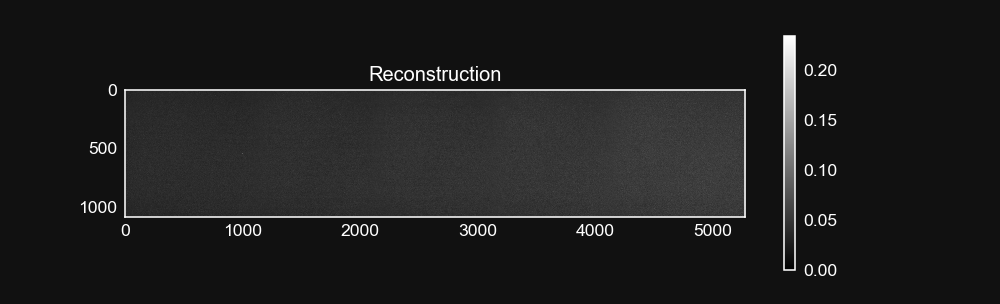

Saved .npz file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03unreg_strip=10_regularize=[].npz
Saved reconstruction .png file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03unreg_strip=10_regularize=[].png
Saved measurement .png file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03unreg_strip=10_regularize=[].png


In [17]:
# Set position segments
# dataset.position_segment_indicies = [0,1,2,3,4,5,6]
# dataset.motiondeblur.position_segment_indicies = [3]
dataset.frame_mask = list(range(355,360))

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode=0, use_psf=False)

# # Perform reconstruction
recon.reconstruct(iteration_count=-1, step_size=1, mode='static', reg_types={})

# # Show result
# recon.show()

recon.show()

recon.save(output_path, filename=recon.dataset.metadata.file_header + 'unreg_strip=' + str(dataset.motiondeblur.position_segment_indicies[0]), formats=['png', 'npz'], save_raw=True, downsample=4)

In [16]:

recon.save(output_path, filename=recon.dataset.metadata.file_header + '_reg_strip=' + str(dataset.motiondeblur.position_segment_indicies[0]), formats=['png', 'npz'], save_raw=True, downsample=4)

Saved .npz file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03_reg_strip=10_regularize=[].npz
Saved reconstruction .png file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03_reg_strip=10_regularize=[].png
Saved measurement .png file to /Users/zfphil/datasets/motiondeblur/output/163c_color_strobe_raster_motiondeblur_2018_05_23_08_45_03_reg_strip=10_regularize=[].png


<IPython.core.display.Javascript object>


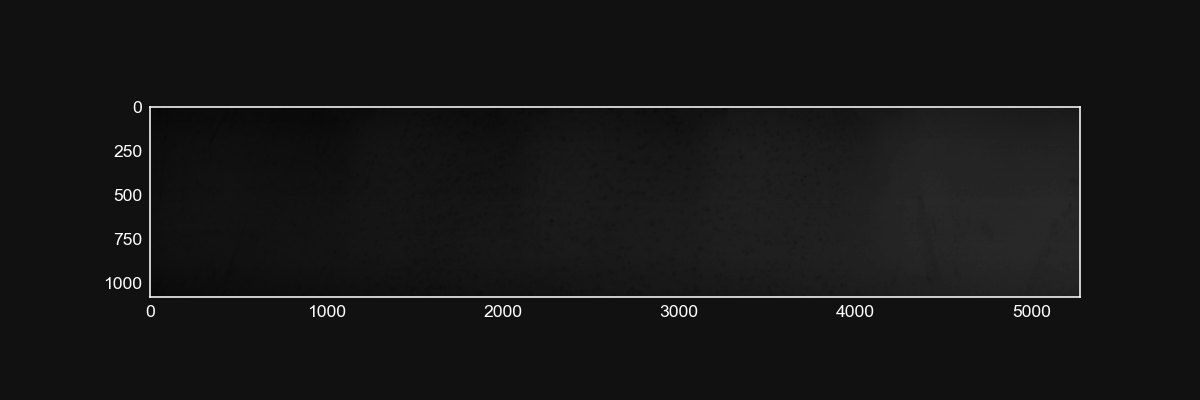

In [15]:
from skimage.restoration import denoise_tv_chambolle
denoised = denoise_tv_chambolle(np.real(recon.object_recovered), weight=0.01)

plt.figure()
plt.imshow(denoised)

recon.object_recovered = denoised

In [ ]:
plt.figure()
plt.imshow(denoised)

In [ ]:
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_reg_strip=' + str(dataset.motiondeblur.position_segment_indicies[0]), formats=['png', 'npz'], save_raw=True, downsample=4)

## Solve for all "Strips" in Dataset

In [ ]:
for strip_index in dataset.motiondeblur.position_segment_indicies_full:
    
    dataset.clearFramesFromMemory()
    
    # Set position segment
    dataset.motiondeblur.position_segment_indicies = [strip_index]
    
    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode=0, use_psf=True)

    # Perform reconstruction
    recon.reconstruct(iteration_count=-1, step_size=0.7, mode='static', reg_types={'tv': 5e-4})
    
    # Save result
    recon.save(output_path, filename='strobe_raw' + '_strip=' + str(strip_index), formats=['npz'], save_raw=True)

## Debugging Using Single Strip

In [ ]:
# Set position segments
# dataset.position_segment_indicies = [0,1,2,3,4,5,6]
dataset.motiondeblur.position_segment_indicies = [0]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode=0, use_psf=True)

# Perform reconstruction
recon.reconstruct(iteration_count=-1, step_size=1, mode='static', frame_number=3, reg_types={'tv': 5e-4})

# Show result
recon.show()

# recon.save(output_dir, filename=recon.dataset.metadata.file_header + '_strip=' + str(strip_index), formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
plt.figure()
plt.imshow(recon.y)